# Multi Label Classification: Auto Tagging

Importing required Libraries


In [38]:


import joblib
import nltk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, FreqDist
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

Loading Dataset

In [39]:
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")
dataset

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Climate risk and response: Physical hazards an...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,New Accenture Research Finds Leaders and Emplo...,Organization,Talent|Culture & transformational change
2,"Me, my life, my wallet - The widespread and im...","Growth, Marketing & Sales",Customer experience
3,The next normal arrives: Trends that will defi...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,Our 2021 technology predictions for businesses...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...
...,...,...,...
19995,How to reshape aerospace and defence supply ch...,Aerospace & Defense|Operations|Risk & Resilience,Aerospace & Defense- Other|Manufacturing & sup...
19996,Why current challenges make a more sustainable...,Banking,Retail banking|Consumer Credit
19997,What companies should consider when making cli...,Strategy & Corporate Finance|Sustainability,CFO-Finance-Capital Markets|Sustainability inv...
19998,Post-Brexit trade: Navigating the disruption -...,Operations,Operations- Other


Dataset Information

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SUMMARY        20000 non-null  object
 1   PRACTICE/AREA  20000 non-null  object
 2   SL/SUB-AREA    20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


Dataset Statistics


In [41]:
dataset.describe()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
count,20000,20000,20000
unique,19985,5910,12637
top,Survey: US consumer sentiment during the coron...,Organization,Economic development
freq,3,1034,347


### Data-Preprocessing


In [42]:
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"],
    dataset["PRACTICE/AREA"],
    dataset["SL/SUB-AREA"],
    test_size=0.1,
    random_state=41,
)

In [43]:
testingDataset = pd.concat([X_test_1, y_test_1], axis=1)
testingDataset.reset_index(drop=True, inplace=True)
testingDataset.head()

,SUMMARY,PRACTICE/AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...


In [44]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [45]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    document = document.lower()
    # Remove punctuation and numbers
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)
    tokens = word_tokenize(document)
    tokens = list(set(tokens))
    # Remove stopwords, Lemmatize, and then rejoin the words
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document

In [46]:
X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

In [47]:
# X_train_1.head()
# y_train_1.head()

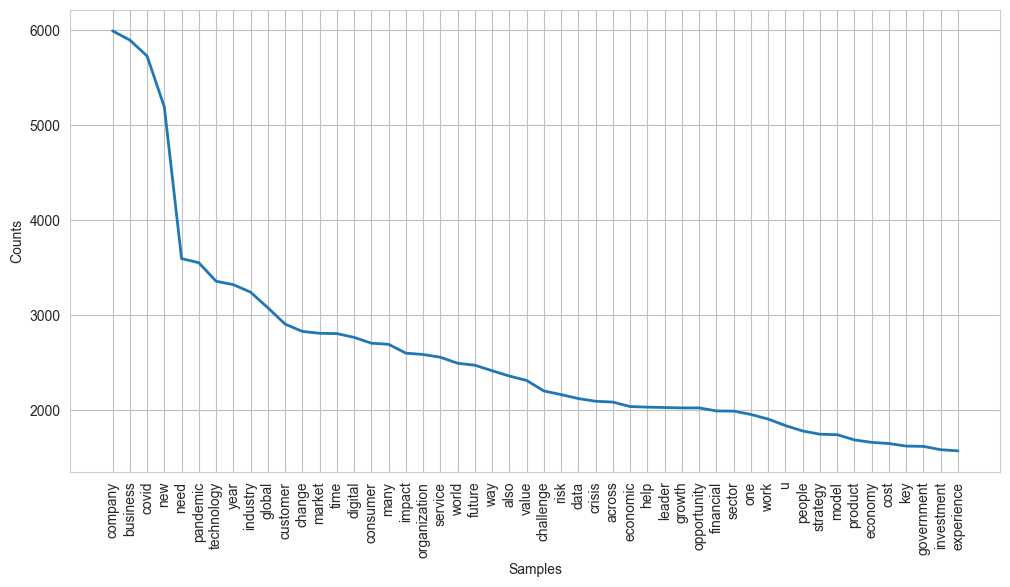

Total Words Count:  840500


In [48]:
corpus = " ".join(X_train_1)

tokens = nltk.word_tokenize(corpus)
fdist = FreqDist(tokens)

plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()
print("Total Words Count: ", len(tokens))

In [49]:
y_train_1 = y_train_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_1 = y_test_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

In [51]:
label_counts = pd.Series([label for sublist in y_train_1 for label in sublist]).value_counts()
print('Label Count: ', label_counts.shape[0], '\n', label_counts)

Label Count:  31 
 Strategy & Corporate Finance          6411
Organization                          5965
Digital & Analytics (Dna)             5415
Mckinsey Technology                   3433
Growth, Marketing & Sales             3382
Public And Social Sector              3120
Risk & Resilience                     2730
Operations                            2362
Banking                               2290
Sustainability                        1573
Retail                                1091
Telecom, Media & Technology           1043
Healthcare                            1026
Consumer Goods                         740
Insurance                              729
Energy                                 707
Travel, Logistics & Infrastructure     685
Automotive                             636
Private Equity                         563
Pharmaceuticals                        552
Basic Materials                        288
Advanced Electronics                   259
Aerospace & Defense                

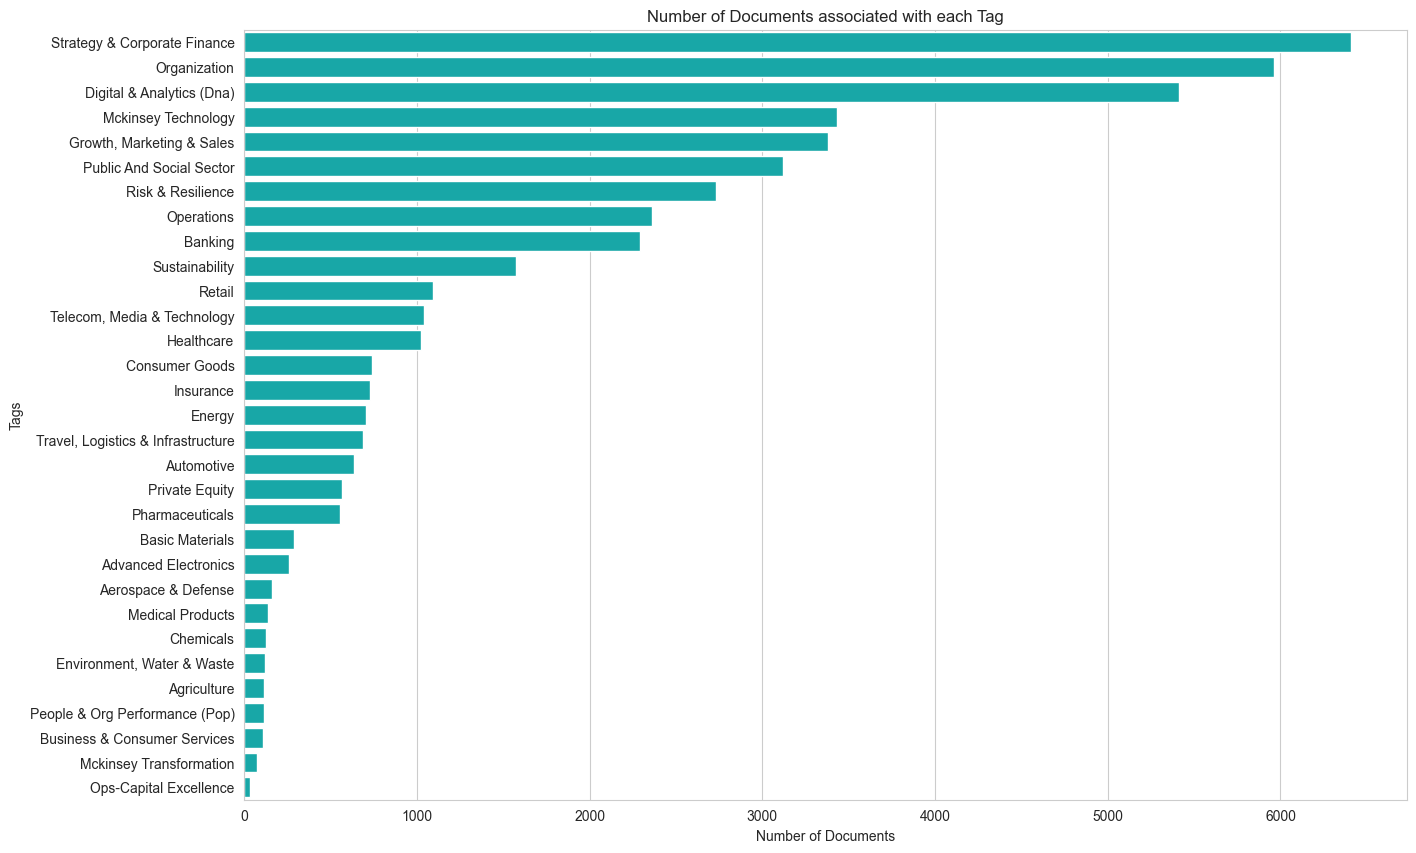

In [52]:
plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.values, y=label_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

In [53]:
min_threshold = 100
frequent_labels = label_counts[label_counts >= min_threshold].index.tolist()

y_train_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_train_1]
y_test_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_test_1]

In [54]:
y_train_1 = pd.Series(y_train_1, name='PRACTICE/AREA')
y_test_1 = pd.Series(y_test_1, name='PRACTICE/AREA')

In [55]:
y_train_1.head()

0    [Strategy & Corporate Finance, Risk & Resilien...
1    [Mckinsey Technology, Telecom, Media & Technol...
2                   [Public And Social Sector, Retail]
3    [Strategy & Corporate Finance, Organization, G...
4              [Automotive, Growth, Marketing & Sales]
Name: PRACTICE/AREA, dtype: object

In [56]:
mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
joblib.dump(mlb, "mlb1.joblib")
y_train_1.head()

,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,Digital & Analytics (Dna),...,People & Org Performance (Pop),Pharmaceuticals,Private Equity,Public And Social Sector,Retail,Risk & Resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
X_train_2 = X_train_1
X_test_2 = X_test_1
X_train_2.reset_index(drop=True, inplace=True)
X_test_2.reset_index(drop=True, inplace=True)
X_train_2 = pd.concat([X_train_2, y_train_1], axis=1)
X_test_2 = pd.concat([X_test_2, y_test_1], axis=1)
X_train_2.head()
X_test_2.head()

,SUMMARY,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,...,People & Org Performance (Pop),Pharmaceuticals,Private Equity,Public And Social Sector,Retail,Risk & Resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,say build costello uk since also work digital ...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,middle decarbonization road place stronger sin...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,cautiously optimistic postcovid chinese brand ...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,vulnerability payer insurer three reimagine ec...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,visualizing case detailed possible come genera...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [58]:
tag_counts = y_train_1.sum(numeric_only=True) + y_test_1.sum(numeric_only=True)
print("Label Count: ", tag_counts.shape[0], "\n", tag_counts)

Label Count:  29 
 Advanced Electronics                   277
Aerospace & Defense                    188
Agriculture                            132
Automotive                             689
Banking                               2551
Basic Materials                        323
Business & Consumer Services           118
Chemicals                              142
Consumer Goods                         842
Digital & Analytics (Dna)             6009
Energy                                 776
Environment, Water & Waste             129
Growth, Marketing & Sales             3741
Healthcare                            1128
Insurance                              802
Mckinsey Technology                   3826
Medical Products                       155
Operations                            2623
Organization                          6618
People & Org Performance (Pop)         127
Pharmaceuticals                        608
Private Equity                         622
Public And Social Sector           

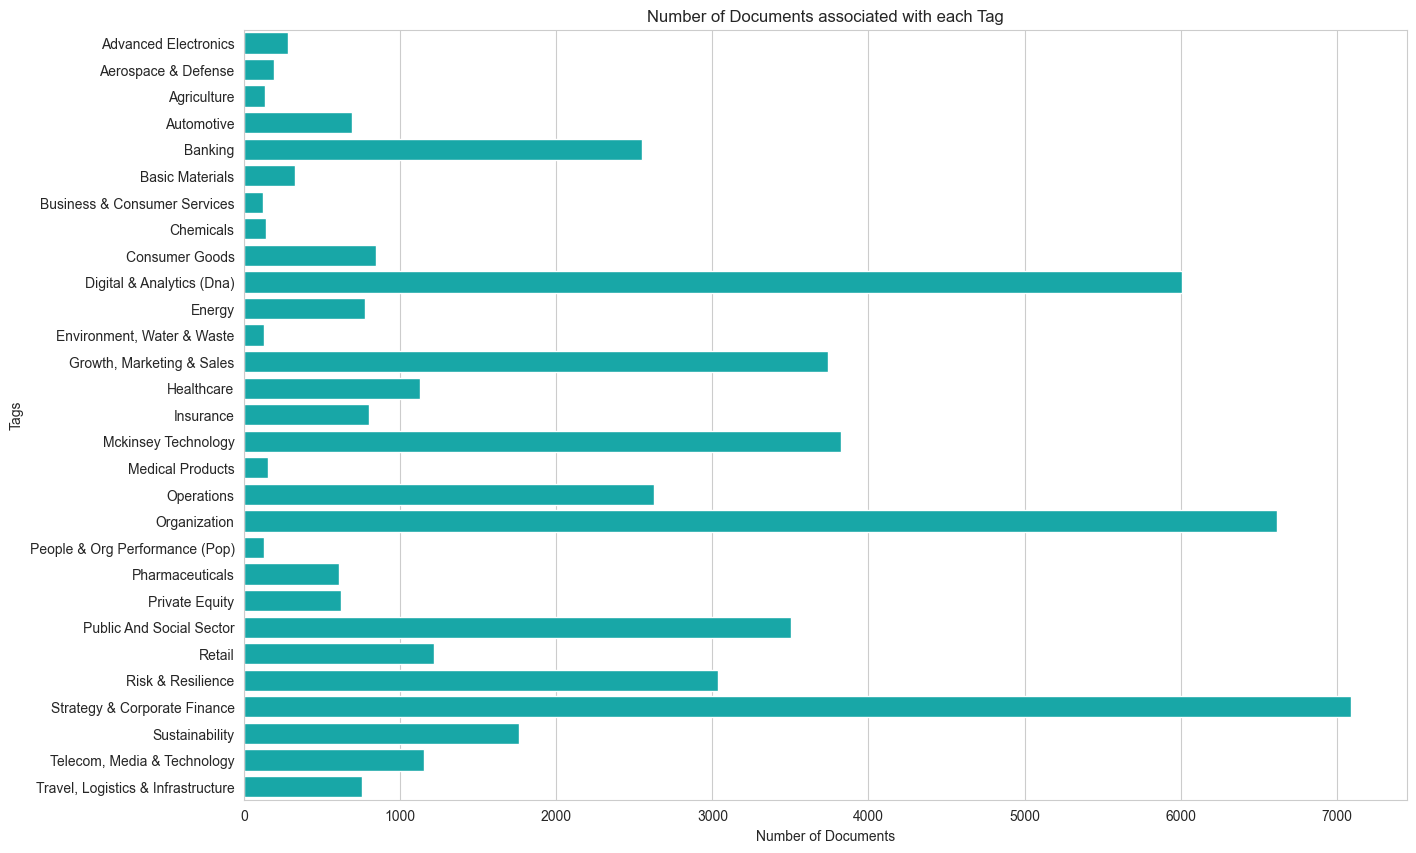

In [59]:
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

Text Vectorization

In [60]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
joblib.dump(tfidf, "tfidfmodel.joblib")
X_train_tfidf_1.shape, X_test_tfidf_1.shape

((18000, 507365), (2000, 507365))

### Model Training


Decision Tree Classifier


In [17]:
from sklearn.tree import DecisionTreeClassifier

DTC_1 = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy", random_state=0))
dtc1 = DTC_1.fit(X_train_tfidf_1, y_train_1)

Random Forest Classifier


In [18]:
RFC_1 = OneVsRestClassifier(RandomForestClassifier())
rfc1 = RFC_1.fit(X_train_tfidf_1, y_train_1)

Stochastic Gradient Descent Classifier


In [23]:
SGD_1 = OneVsRestClassifier(SGDClassifier())
sgd1 = SGD_1.fit(X_train_tfidf_1, y_train_1)

Logistic Regression


In [24]:
LR_1 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr1 = LR_1.fit(X_train_tfidf_1, y_train_1)

Support Vector Classifier


In [61]:
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)
joblib.dump(svc1, "LinearSVC.joblib")

['LinearSVC.joblib']

XGBoost Classifier


In [22]:
XGB_1 = OneVsRestClassifier(XGBClassifier())
xgb1 = XGB_1.fit(X_train_tfidf_1, y_train_1)

Voting Classsifier


In [23]:
log_clf = LogisticRegression(solver="liblinear")
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma="auto", probability=True)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("xgb", xgb_clf)],
    voting="soft",
)

ovr_voting_1 = OneVsRestClassifier(voting_clf)
ovr_voting_1.fit(X_train_tfidf_1, y_train_1)  # Make sure to fit it with your train data

OneVsRestClassifier(estimator=VotingClassifier(estimators=[('lr',
                                                            LogisticRegression(solver='liblinear')),
                                                           ('rf',
                                                            RandomForestClassifier()),
                                                           ('svc',
                                                            SVC(gamma='auto',
                                                                probability=True)),
                                                           ('xgb',
                                                            XGBClassifier(base_score=None,
                                                                          booster=None,
                                                                          callbacks=None,
                                                                          colsample_bylevel=None,
                                                                          colsample_bynode=None,
                                                                          colsample_bytree=None,
                                                                          device=None,
                                                                          early_stopping_rounds=None...
                                                                          importance_type=None,
                                                                          interaction_constraints=None,
                                                                          learning_rate=None,
                                                                          max_bin=None,
                                                                          max_cat_threshold=None,
                                                                          max_cat_to_onehot=None,
                                                                          max_delta_step=None,
                                                                          max_depth=None,
                                                                          max_leaves=None,
                                                                          min_child_weight=None,
                                                                          missing=nan,
                                                                          monotone_constraints=None,
                                                                          multi_strategy=None,
                                                                          n_estimators=100,
                                                                          n_jobs=None,
                                                                          num_parallel_tree=None,
                                                                          random_state=None, ...))],
                                               voting='soft'))

In [38]:
from sklearn import metrics


def Evaluate_Matrix(y_true, y_pred):
    eva_matrix = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracies = []
    precision = []
    recall = []
    f1 = []
    jaccard = []
    hamming = []

    for y_trues, y_preds in zip(y_true, y_pred):
        pre_mlcm = multilabel_confusion_matrix(y_true, y_pred)

        accuracies.append(accuracy_score(y_trues, y_preds))
        # recall.append(metrics.recall_score(y_trues, y_preds, average="micro"))
        recall.append((pre_mlcm[:, 0, 0] / (pre_mlcm[:, 0, 0] + pre_mlcm[:, 1, 0])))
        precision.append(
            metrics.precision_score(
                y_trues, y_preds, average="weighted", zero_division=0
            )
        )
        jaccard.append(
            jaccard_score(y_trues, y_preds, average="weighted", zero_division=0)
        )
        f1.append(
            metrics.f1_score(y_trues, y_preds, average="weighted", zero_division=0)
        )
        hamming.append(hamming_loss(y_trues, y_preds))

    eva_matrix.append(np.mean(accuracies))
    eva_matrix.append(np.mean(recall))
    eva_matrix.append(np.mean(precision))
    eva_matrix.append(np.mean(jaccard))
    eva_matrix.append(np.mean(f1))
    eva_matrix.append(np.mean(hamming))

    return eva_matrix

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, jaccard_score, \
    hamming_loss


# Function to check exact match
def exact_match(y_true, y_pred):
    return np.array_equal(y_true, y_pred)


# Initialize model comparison dictionary
model_comparison = {}

# List of models to evaluate
models = [
    # ("SGD", sgd1),
    # ("LogisticRegression", lr1),
    ("LinearSVC", svc1)
]

# Loop through models and evaluate
for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)

    # Evaluate model performance
    matrix = Evaluate_Matrix(y_test_1, predictions)

    # Count exact matches and mismatches
    exact_matches = sum([exact_match(y_test_1.iloc[i].values, predictions[i]) for i in range(len(y_test_1))])
    mismatches = len(y_test_1) - exact_matches

    # Store evaluation metrics
    model_comparison[model_name] = {
        "Accuracy": matrix[0],
        "Recall/Sensy": matrix[1],
        "Precision": matrix[2],
        "Jaccard Score": matrix[3],
        "F1 Score": matrix[4],
        "Hamming Loss": matrix[5],
        "Exact Matches": exact_matches,
        "Mismatches": mismatches,
        "Total Samples": len(y_test_1)
    }

# Create a DataFrame from the model comparison dictionary
model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

# Print the model scores DataFrame
model_scores


,Accuracy,Recall/Sensy,Precision,Jaccard Score,F1 Score,Hamming Loss,Exact Matches,Mismatches,Total Samples
LinearSVC,0.941793,0.949302,0.938375,0.898314,0.933828,0.058207,412,1588,2000


In [64]:
print(
    classification_report(
        y_test_1,
        predictions,
        output_dict=False,
        zero_division=0,
        target_names=mlb.classes_,
    )
)

                                    precision    recall  f1-score   support

              Advanced Electronics       0.67      0.22      0.33        18
               Aerospace & Defense       1.00      0.11      0.20        27
                       Agriculture       1.00      0.13      0.24        15
                        Automotive       0.89      0.78      0.83        54
                           Banking       0.86      0.70      0.78       261
                   Basic Materials       1.00      0.26      0.41        35
      Business & Consumer Services       0.00      0.00      0.00         9
                         Chemicals       0.75      0.43      0.55        14
                    Consumer Goods       0.69      0.30      0.42       102
         Digital & Analytics (Dna)       0.70      0.54      0.61       596
                            Energy       0.88      0.54      0.67        69
        Environment, Water & Waste       0.00      0.00      0.00        10
         Gr

#### Classification


In [16]:
text = [
    "The CFO's role in helping companies navigate the coronavirus crisis - Strong, steady leadership from the finance organization is critical for addressing immediate concerns about safety and survival, stabilizing the business in the near term, and positioning it for recovery."
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc1.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Risk & Resilience', 'Strategy & Corporate Finance')]

In [26]:
GEN_PRACTICE_AREA = []

for value in testingDataset["SUMMARY"]:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = svc1.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_PRACTICE/AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

[('Public And Social Sector',)]
[('Sustainability',)]
[('Consumer Goods', 'Growth, Marketing & Sales', 'Retail')]
[('Healthcare',)]
[('Digital & Analytics (Dna)',)]
[('Operations',)]
[('Private Equity',)]
[('Banking',)]
[('Risk & Resilience', 'Strategy & Corporate Finance')]
[('Digital & Analytics (Dna)', 'Insurance', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Consumer Goods', 'Growth, Marketing & Sales')]
[('Digital & Analytics (Dna)', 'Mckinsey Technology')]
[()]
[('Telecom, Media & Technology',)]
[('Strategy & Corporate Finance',)]
[('Banking', 'Risk & Resilience', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Insurance', 'Risk & Resilience')]
[('Digital & Analytics (Dna)', 'Growth, Marketing & Sales', 'Retail', 'Telecom, Media & Technology')]
[('Digital & Analytics (Dna)', 'Growth, Marketing & Sales')]
[('Growth, Marketing & Sales', 'Retail')]
[('Growth, Marketing & Sales',)]
[('Digital & Analytics (Dna)', 'Energy', 'Operations', 'Strategy & Corporate Finance

In [66]:
testingDataset = pd.concat([testingDataset, predData], axis=1)
testingDataset.head()
# newDataset2.to_excel("generated_tags.xlsx", index=False)
# x = pd.read_excel('generated_tags.xlsx')
# x.head()

NameError: name 'predData' is not defined

### 2nd Level Prediction


In [68]:
tfidf2 = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_2 = tfidf2.fit_transform(X_train_2)
X_test_tfidf_2 = tfidf2.transform(X_test_2)
joblib.dump(tfidf2, "tfidfmodel2.joblib")
X_train_tfidf_2.shape, X_test_tfidf_2.shape

((30, 82), (30, 82))

In [69]:
X_train_tfidf_2

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 84 stored elements and shape (30, 82)>

In [70]:
y_test_2.reset_index(drop=True, inplace=True)
testingDataset = pd.concat([testingDataset, y_test_2], axis=1)
testingDataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,Public infrastructure & cities|Capital excelle...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,Sustainability strategy & portfolio|Decarboniz...
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...",Consumer Goods- Other|Marketing strategy- bra...
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,Healthcare providers|M&A - S&CF|Manufacturing ...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,Data transformation|PSSP- Other|Software|Digit...


y_train_2 = y_train_2.str.split("|")
y_test_2 = y_test_2.str.split("|")

y_train_2.head()

In [71]:
y_train_2 = y_train_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_2 = y_test_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

In [72]:
label_counts = pd.Series([label for sublist in y_train_2 for label in sublist]).value_counts()
print('Label Count: ', label_counts.shape[0])
label_counts

Label Count:  254


Dna Powered-Other Topics          4096
Talent                            3598
Customer Experience               2544
Corporate & Portfolio Strategy    2174
Cfo-Finance-Capital Markets       1922
                                  ... 
Wealth And Asset Management          1
Biosystems & Land Use                1
Auction Houses                       1
Security Systems Services            1
Pe Due Diligence                     1
Name: count, Length: 254, dtype: int64

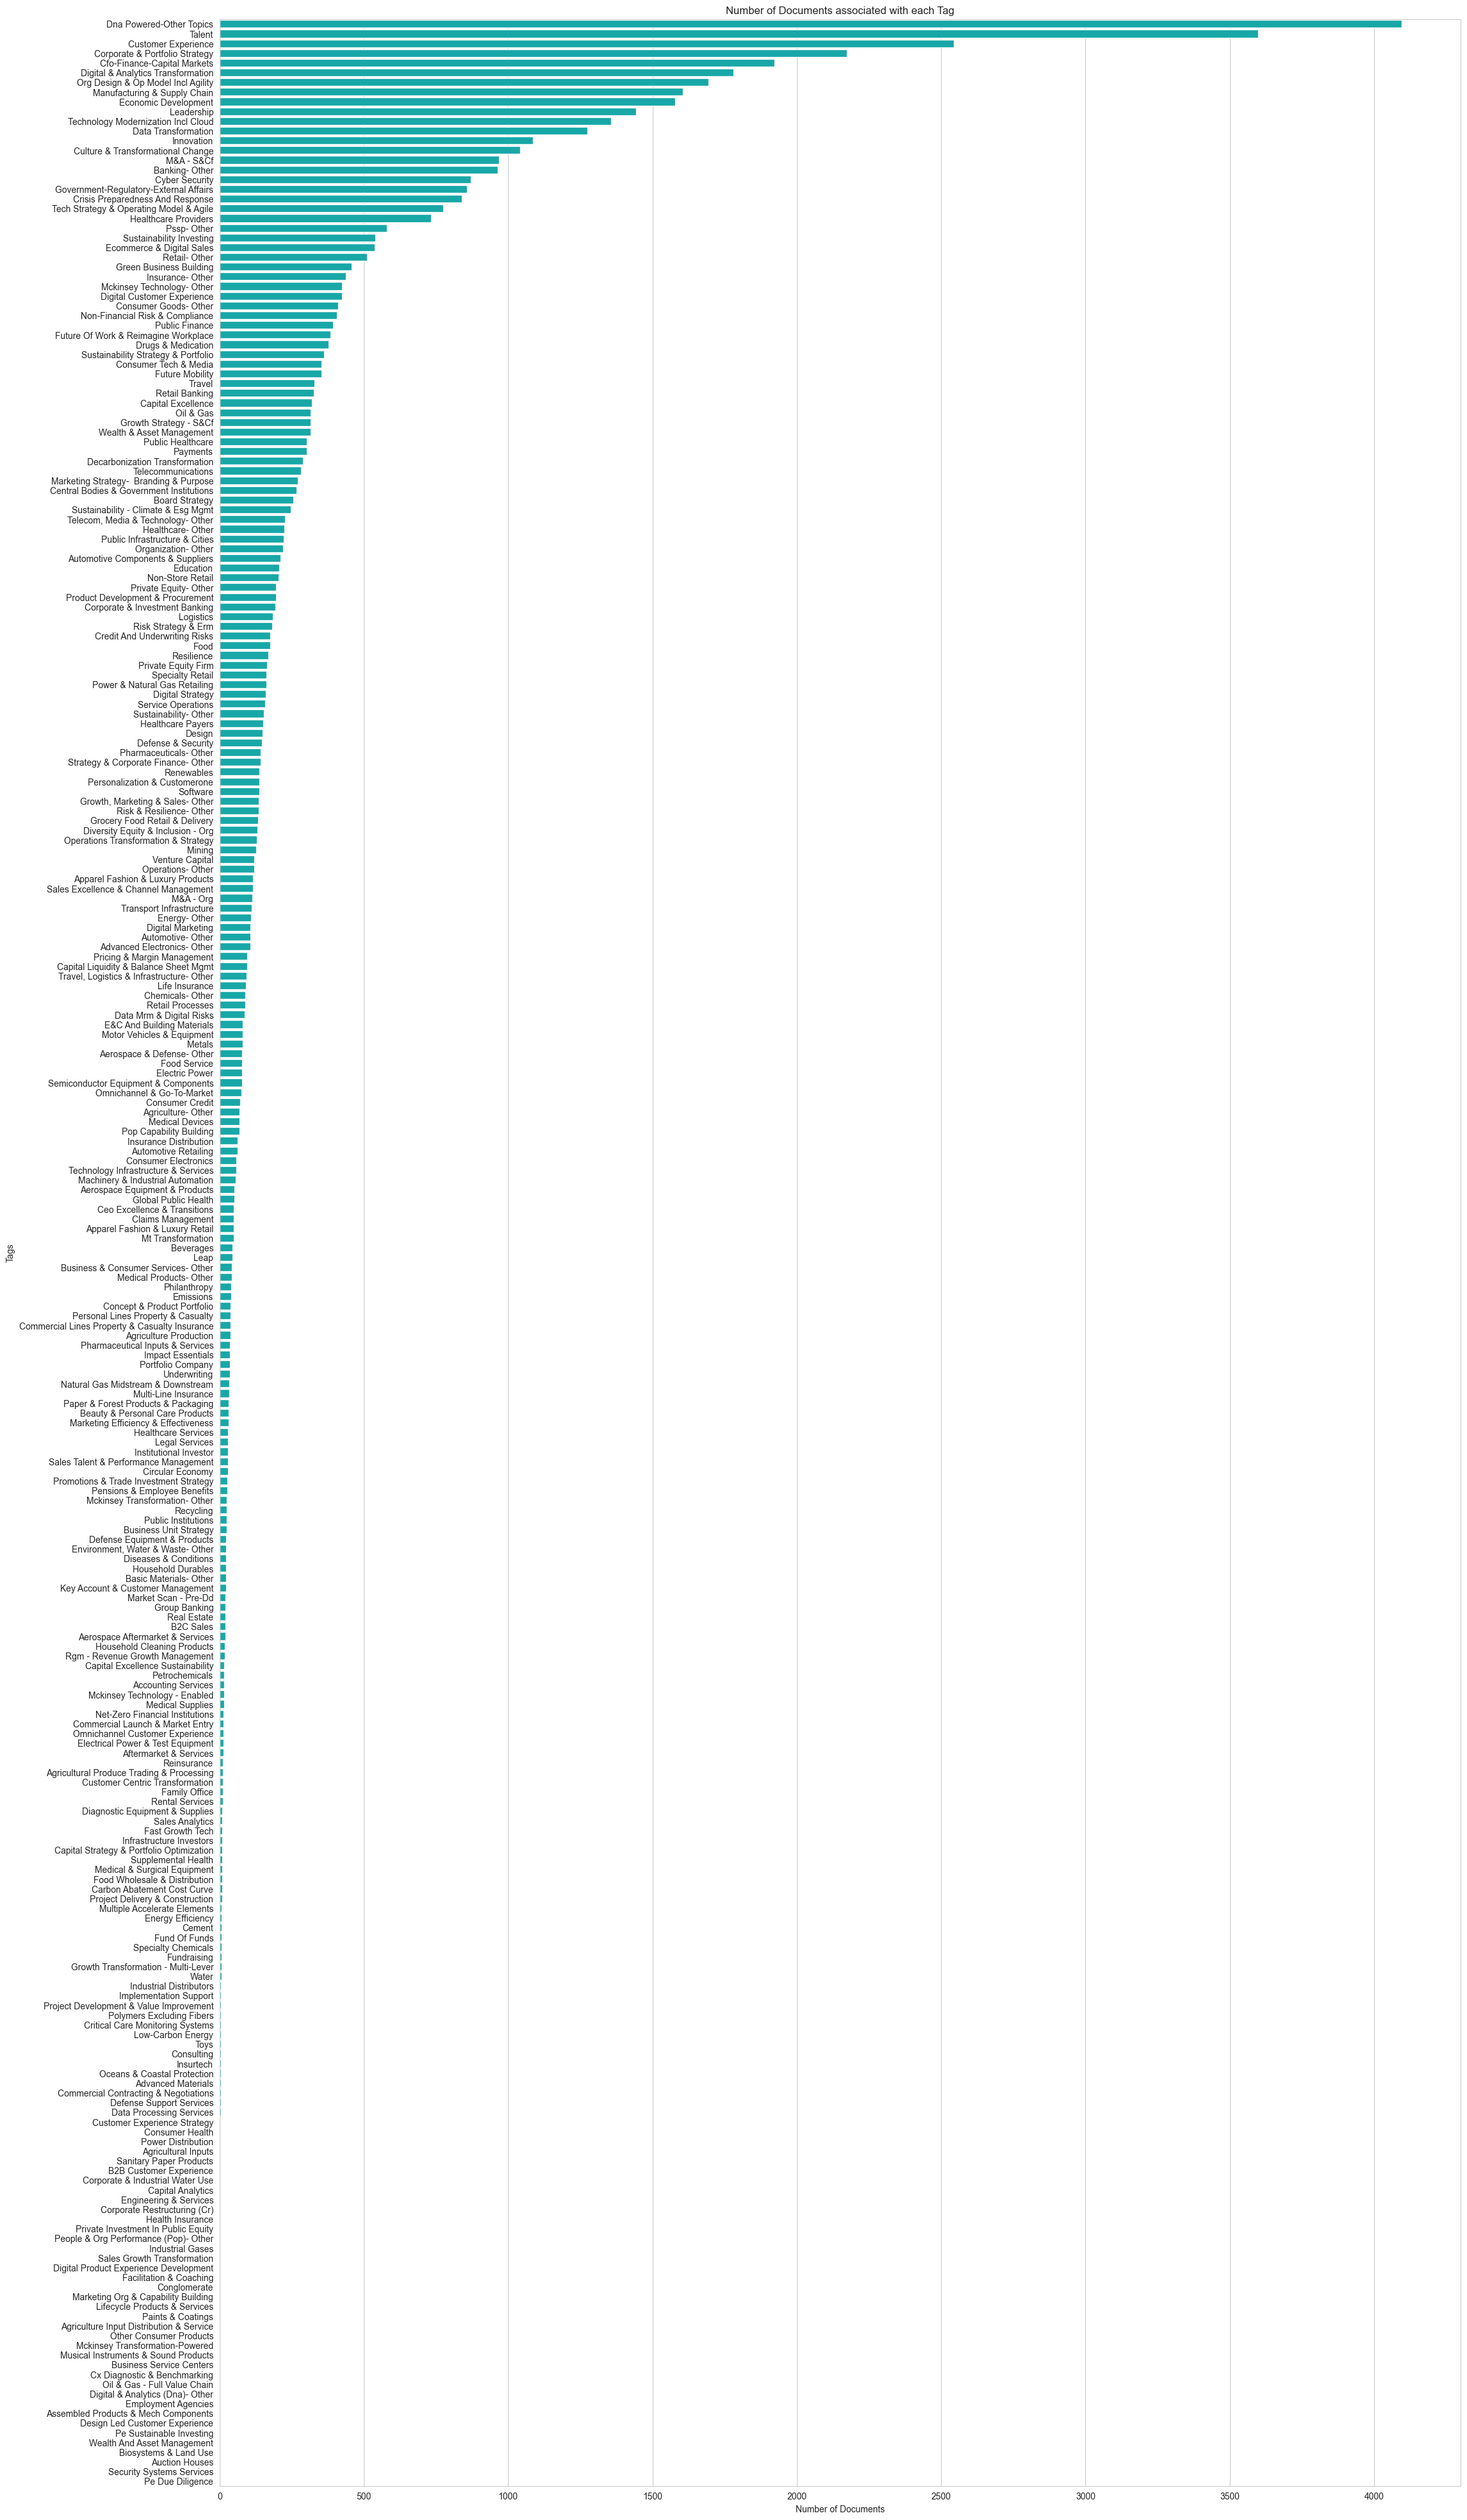

In [73]:
plt.figure(figsize=(25, 50))
sns.barplot(x=label_counts.values, y=label_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

In [74]:
min_threshold = 10
frequent_labels = label_counts[label_counts >= min_threshold].index.tolist()
y_train_2 = [[label for label in sublist if label in frequent_labels] for sublist in y_train_2]
y_test_2 = [[label for label in sublist if label in frequent_labels] for sublist in y_test_2]
y_train_2 = pd.Series(y_train_2, name='SL/SUB-AREA')
y_test_2 = pd.Series(y_test_2, name='SL/SUB-AREA')
y_train_2.head()

0    [Corporate & Portfolio Strategy, Crisis Prepar...
1    [Mckinsey Technology- Other, Telecommunication...
2                [Economic Development, Retail- Other]
3    [Corporate & Portfolio Strategy, Talent, Sales...
4    [Future Mobility, Customer Experience, Automot...
Name: SL/SUB-AREA, dtype: object

In [75]:
mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_test_2 = mlb2.transform(y_test_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)
y_train_2.head()

,Accounting Services,Advanced Electronics- Other,Aerospace & Defense- Other,Aerospace Aftermarket & Services,Aerospace Equipment & Products,Aftermarket & Services,Agricultural Produce Trading & Processing,Agriculture Production,Agriculture- Other,Apparel Fashion & Luxury Products,...,Technology Infrastructure & Services,Technology Modernization Incl Cloud,"Telecom, Media & Technology- Other",Telecommunications,Transport Infrastructure,Travel,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Wealth & Asset Management
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
joblib.dump(mlb2, "mlb2.joblib")

['mlb2.joblib']

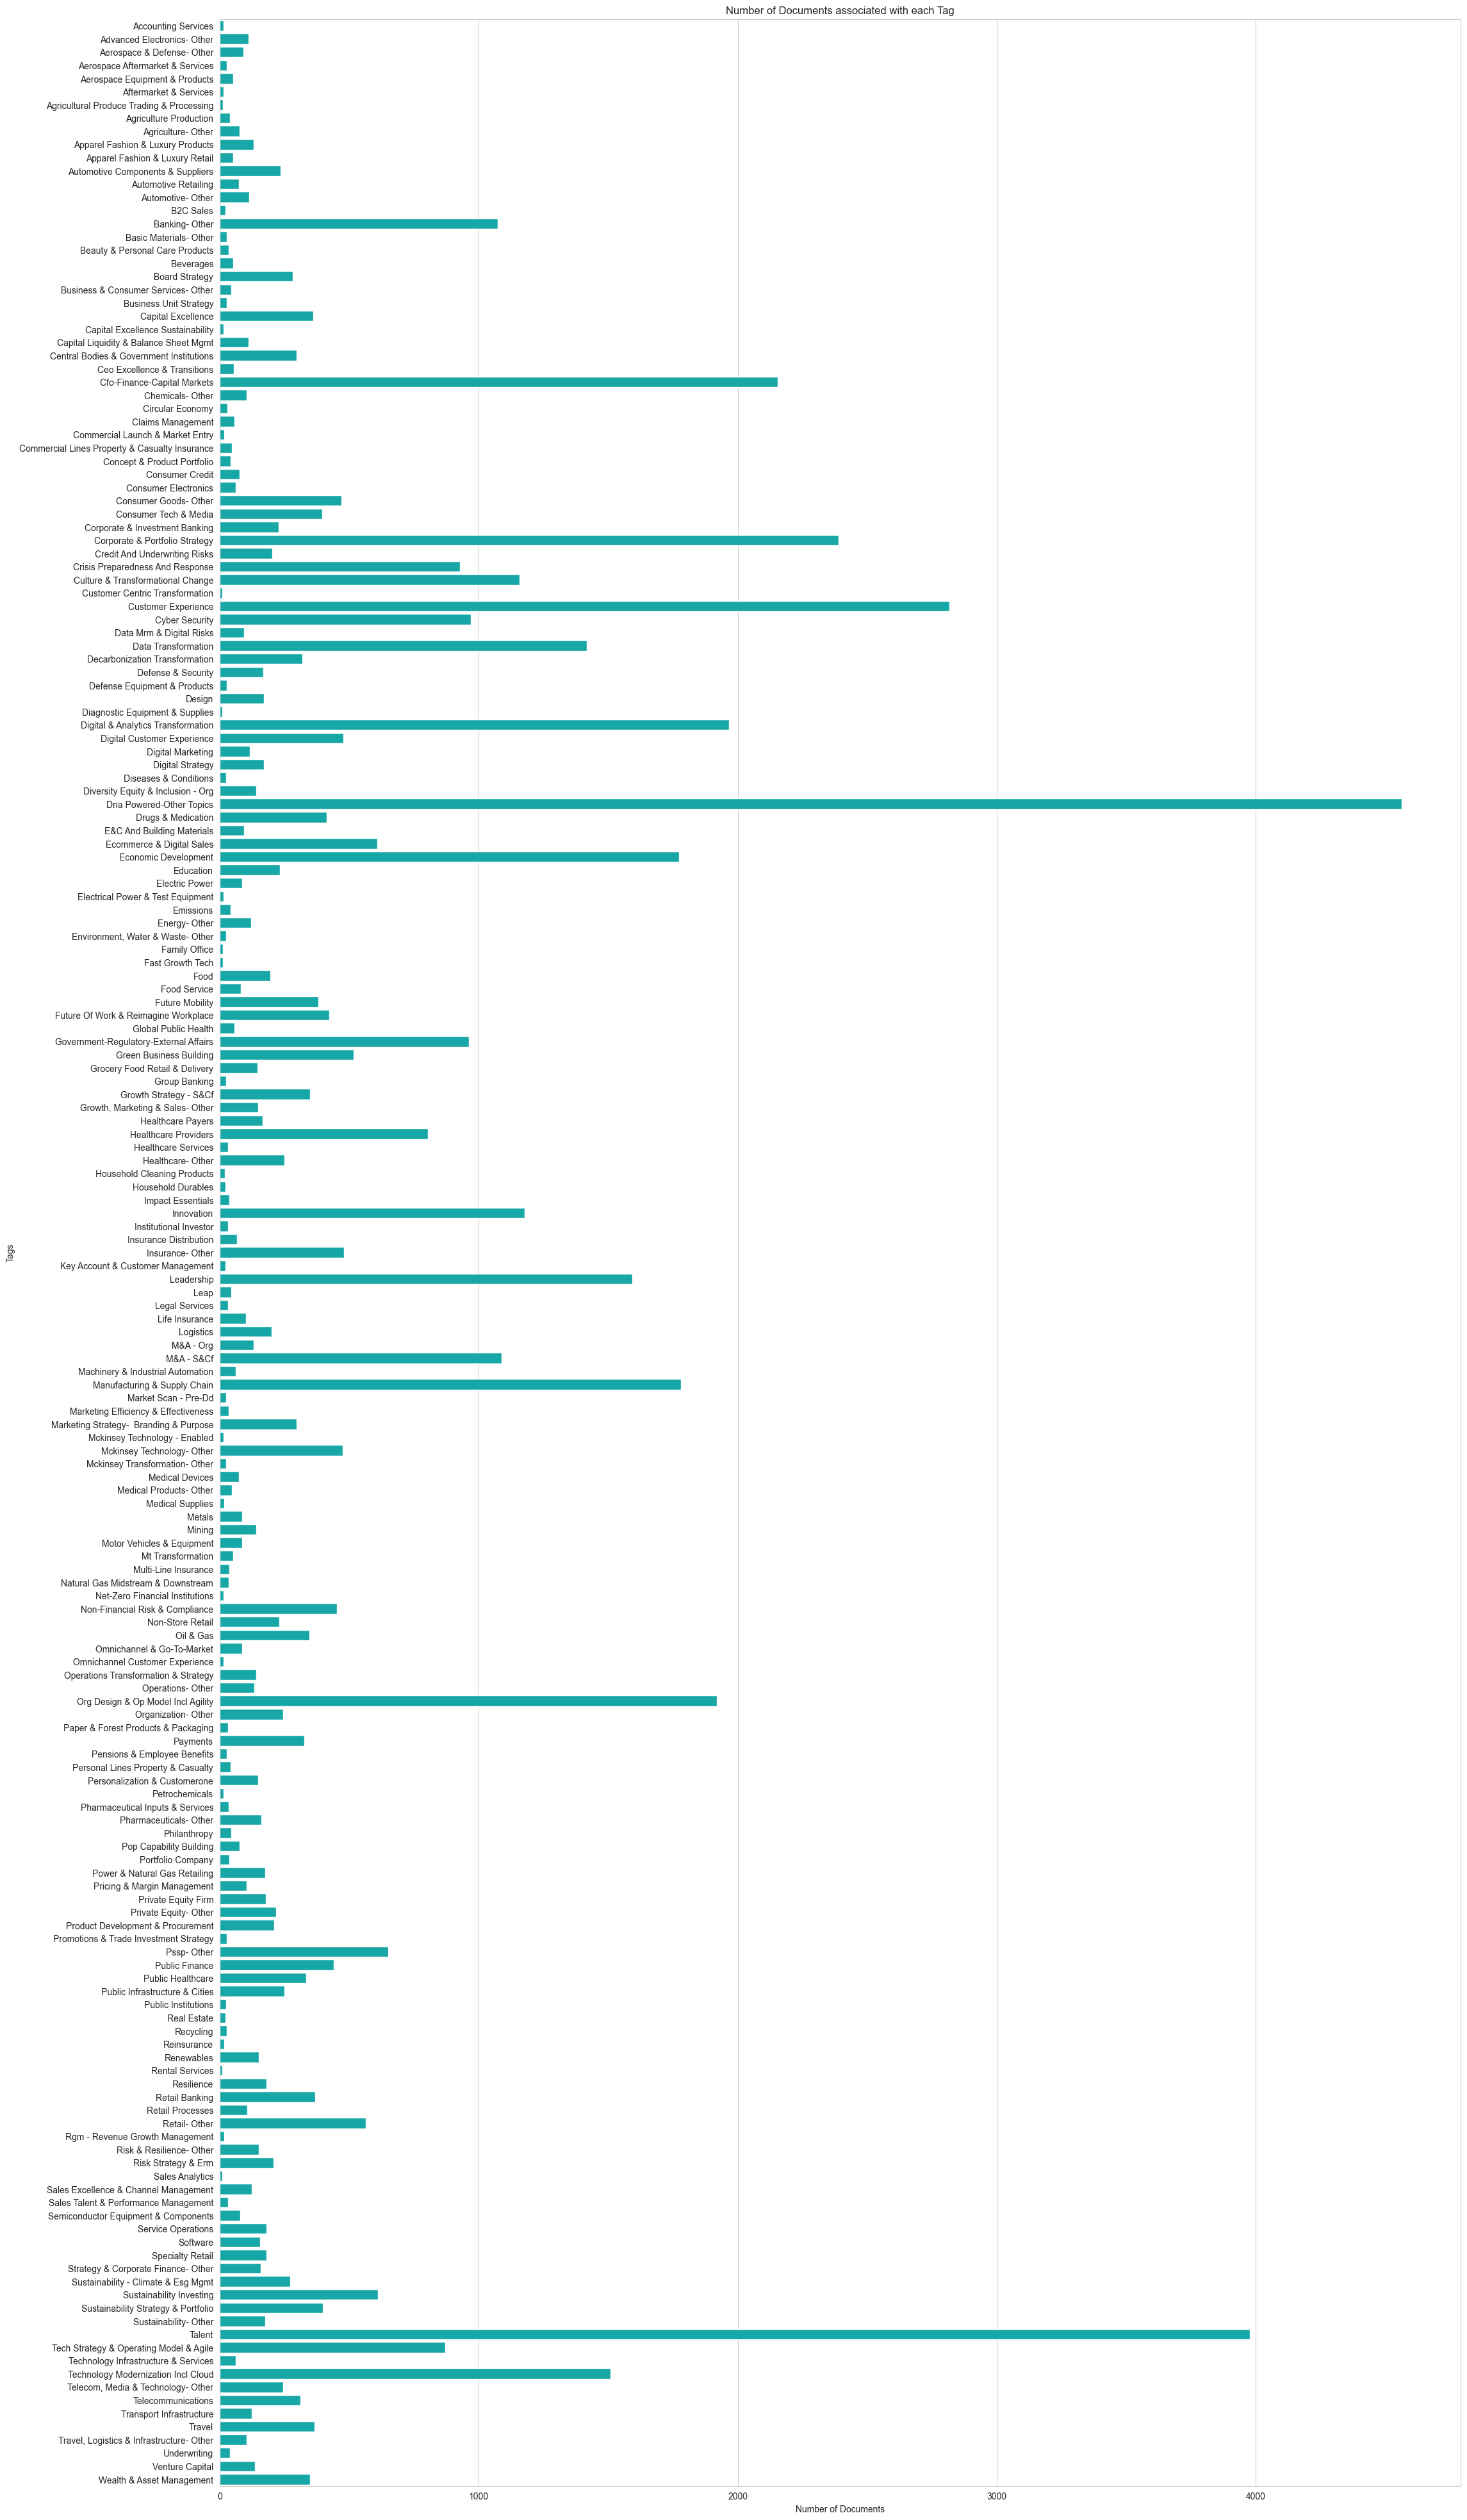

Total Tags:  187


In [77]:
tag_counts = y_train_2.sum(numeric_only=True) + y_test_2.sum(numeric_only=True)

# Plot
plt.figure(figsize=(25, 50))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()
print("Total Tags: ", tag_counts.shape[0])

In [35]:
DTC_2 = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy", random_state=0))
dtc2 = DTC_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
RFC_2 = OneVsRestClassifier(RandomForestClassifier())
rfc2 = RFC_2.fit(X_train_tfidf_1, y_train_2)

In [46]:
SGD_2 = OneVsRestClassifier(SGDClassifier())
sgd2 = SGD_2.fit(X_train_tfidf_1, y_train_2)

In [47]:
LR_2 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr2 = LR_2.fit(X_train_tfidf_1, y_train_2)

In [ ]:
XGB_2 = OneVsRestClassifier(XGBClassifier())
xgb2 = XGB_2.fit(X_train_tfidf_1, y_train_2)

In [78]:
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_2, y_train_2)

ValueError: Found input variables with inconsistent numbers of samples: [30, 18000]

In [49]:
joblib.dump(svc2, "LinearSVC2.joblib")

['LinearSVC2.joblib']

In [ ]:
log_clf_2 = LogisticRegression(solver="liblinear")
rnd_clf_2 = RandomForestClassifier(n_estimators=100)
xgb_clf_2 = XGBClassifier(n_estimators=100)
svm_clf_2 = SVC(gamma="auto", probability=True)

voting_clf2 = VotingClassifier(
    estimators=[
        ("lr", log_clf_2),
        ("rf", rnd_clf_2),
        ("svc", svm_clf_2),
        ("xgb", xgb_clf_2),
    ],
    voting="soft",
)

ovr_voting_2 = OneVsRestClassifier(voting_clf2)
ovr_voting_2.fit(X_train_tfidf_1, y_train_2)  # Make sure to fit it with your train data

In [39]:
models = [
    # ("RandomForest", rfc2),
    # ("DecisionTree", dtc2),
    # ("SGD", sgd2),
    # ("LogisticRegression", lr2),
    ("LinearSVC", svc2),
    # ("XGBoost", xgb2),
    # ("VotingClassifier", ovr_voting_2),
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    matrix = Evaluate_Matrix(y_test_2, predictions)
    model_comparison[model_name] = {
        "Accuracy": matrix[0],
        "Recall/Sensy": matrix[1],
        "Precision": matrix[2],
        "Jaccard Score": matrix[3],
        "F1 Score": matrix[4],
        "Hamming Loss": matrix[5],
    }

    # joblib.dump(model, model_name + "2.joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

,Accuracy,Recall/Sensy,Precision,Jaccard Score,F1 Score,Hamming Loss
LinearSVC,0.98596,0.987229,0.980198,0.973565,0.981728,0.01404


In [37]:
text = [
    "The CFO's role in helping companies navigate the coronavirus crisis - Strong, steady leadership from the finance organization is critical for addressing immediate concerns about safety and survival, stabilizing the business in the near term, and positioning it for recovery."
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc2.predict(text_tfidf)
predicted_labels = mlb2.inverse_transform(predictions)
predicted_labels

[('Cfo-Finance-Capital Markets', 'Crisis Preparedness And Response')]

In [60]:
GEN_PRACTICE_AREA = []

for value in testingDataset["SUMMARY"]:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = svc2.predict(text_tfidf)
    predicted_labels = mlb2.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_SL/SUB-AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

[('Dna Powered-Other Topics',)]
[('Green Business Building',)]
[('Customer Experience', 'Marketing Strategy-  Branding & Purpose')]
[('Healthcare Payers',)]
[('Digital & Analytics Transformation',)]
[('Manufacturing & Supply Chain',)]
[('Venture Capital',)]
[()]
[('Board Strategy',)]
[('Insurance- Other',)]
[('Talent',)]
[()]
[('Dna Powered-Other Topics',)]
[('Public Infrastructure & Cities',)]
[()]
[()]
[()]
[('Talent',)]
[('Cyber Security', 'Insurance- Other')]
[('Dna Powered-Other Topics',)]
[('Customer Experience', 'Digital & Analytics Transformation')]
[('Ecommerce & Digital Sales', 'Non-Store Retail')]
[('Customer Experience',)]
[('Dna Powered-Other Topics', 'Manufacturing & Supply Chain')]
[('Automotive Components & Suppliers', 'Future Mobility')]
[('Education',)]
[('Customer Experience', 'Insurance- Other', 'Technology Modernization Incl Cloud')]
[()]
[()]
[()]
[('Consumer Tech & Media', 'Customer Experience', 'Dna Powered-Other Topics', 'Telecommunications')]
[('Talent',)]
[()

In [55]:
testingDataset = pd.concat([testingDataset, predData], axis=1)
testingDataset.head()
testingDataset.to_excel("generated_tag_2.xlsx", index=False)
x = pd.read_excel("generated_tags.xlsx")
x.head()

,SUMMARY,PRACTICE/AREA,GEN_PRACTICE/AREA,SL/SUB-AREA,GEN_SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,"[('Public And Social Sector',)]",Public infrastructure & cities|Capital excelle...,"[('DnA powered-other topics', 'Education', 'He..."
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,"[('Sustainability',)]",Sustainability strategy & portfolio|Decarboniz...,"[('Economic development', 'Green business buil..."
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...","[('Consumer Goods', 'Growth, Marketing & Sales...",Consumer Goods- Other|Marketing strategy- bra...,"[('ECommerce & digital sales', 'Food', 'Market..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,"[('Healthcare',)]",Healthcare providers|M&A - S&CF|Manufacturing ...,"[('Healthcare payers',)]"
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,"[('Digital & Analytics (DnA)', 'McKinsey Techn...",Data transformation|PSSP- Other|Software|Digit...,"[('Government-Regulatory-External Affairs',)]"


In [1]:

import joblib
import pandas as pd
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC

In [2]:

# Load dataset
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")

In [3]:

# Split dataset
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"],
    dataset["PRACTICE/AREA"],
    dataset["SL/SUB-AREA"],
    test_size=0.1,
    random_state=41,
)

In [4]:

# Preprocess text
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    document = document.lower()
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)
    tokens = word_tokenize(document)
    tokens = list(set(tokens))
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document

In [5]:

X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

In [6]:

# Process labels for PRACTICE/AREA
y_train_1 = y_train_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_1 = y_test_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

In [8]:
label_counts = pd.Series([label for sublist in y_train_1 for label in sublist]).value_counts()
print('Label Count: ', label_counts.shape[0], '\n', label_counts)
# Assume label_counts is calculated somewhere
min_threshold = 100
frequent_labels = label_counts[label_counts >= min_threshold].index.tolist()
y_train_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_train_1]
y_test_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_test_1]

Label Count:  31 
 Strategy & Corporate Finance          6411
Organization                          5965
Digital & Analytics (Dna)             5415
Mckinsey Technology                   3433
Growth, Marketing & Sales             3382
Public And Social Sector              3120
Risk & Resilience                     2730
Operations                            2362
Banking                               2290
Sustainability                        1573
Retail                                1091
Telecom, Media & Technology           1043
Healthcare                            1026
Consumer Goods                         740
Insurance                              729
Energy                                 707
Travel, Logistics & Infrastructure     685
Automotive                             636
Private Equity                         563
Pharmaceuticals                        552
Basic Materials                        288
Advanced Electronics                   259
Aerospace & Defense                

In [9]:

y_train_1 = pd.Series(y_train_1, name='PRACTICE/AREA')
y_test_1 = pd.Series(y_test_1, name='PRACTICE/AREA')

In [10]:

mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
joblib.dump(mlb, "mlb1.joblib")

['mlb1.joblib']

In [11]:

# Combine X_train_2 with y_train_1
X_train_2 = X_train_1.reset_index(drop=True)
X_test_2 = X_test_1.reset_index(drop=True)
X_train_2 = pd.concat([X_train_2, y_train_1], axis=1)
X_test_2 = pd.concat([X_test_2, y_test_1], axis=1)

In [19]:
X_train_2 = X_train_2.map(str)
X_test_2 = X_test_2.map(str)

In [26]:
X_train_2

,SUMMARY,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,...,People & Org Performance (Pop),Pharmaceuticals,Private Equity,Public And Social Sector,Retail,Risk & Resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,come supply oil imploding new financialmarket ...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1,develop domain regulator order geofencing orga...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,closure april belief november impact distribut...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,responded conglomerate moved online new shift ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,road emobility achieve massmarket automaker co...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,mean way delivered well reduce preference shif...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
17996,come way paper business examines risk trading ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17997,practical key consideration decisively area fo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17998,justintime resiliency paper april understand a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:

# Vectorize text data
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
joblib.dump(tfidf, "tfidfmodel.joblib")

['tfidfmodel.joblib']

In [13]:

# Train first model
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)
joblib.dump(svc1, "LinearSVC.joblib")

['LinearSVC.joblib']

In [20]:

# Vectorize combined data
tfidf2 = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_2 = tfidf2.fit_transform(X_train_2.apply(lambda x: " ".join(x), axis=1))
X_test_tfidf_2 = tfidf2.transform(X_test_2.apply(lambda x: " ".join(x), axis=1))
joblib.dump(tfidf2, "tfidfmodel2.joblib")

['tfidfmodel2.joblib']

In [21]:

# Process labels for SL/SUB-AREA
y_train_2 = y_train_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_2 = y_test_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

In [22]:

min_threshold = 10
frequent_labels = label_counts[label_counts >= min_threshold].index.tolist()
y_train_2 = [[label for label in sublist if label in frequent_labels] for sublist in y_train_2]
y_test_2 = [[label for label in sublist if label in frequent_labels] for sublist in y_test_2]
y_train_2 = pd.Series(y_train_2, name='SL/SUB-AREA')
y_test_2 = pd.Series(y_test_2, name='SL/SUB-AREA')

In [23]:

mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_test_2 = mlb2.transform(y_test_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)
joblib.dump(mlb2, "mlb2.joblib")

['mlb2.joblib']

In [24]:

# Debugging shapes
print(f"X_train_tfidf_2 shape: {X_train_tfidf_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")

X_train_tfidf_2 shape: (18000, 506911)
y_train_2 shape: (18000, 0)


In [36]:

# Train second model
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_2, y_train_2)
joblib.dump(svc2, "LinearSVC2.joblib")

['LinearSVC2.joblib']

In [ ]:

import joblib
import pandas as pd
from nltk import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [ ]:

# Load dataset
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")

In [ ]:

# Split dataset
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"],
    dataset["PRACTICE/AREA"],
    dataset["SL/SUB-AREA"],
    test_size=0.1,
    random_state=41,
)

In [ ]:

# Preprocess text
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    document = document.lower()
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)
    tokens = word_tokenize(document)
    tokens = list(set(tokens))
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document

In [ ]:

X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

In [ ]:

# Process labels for PRACTICE/AREA
y_train_1 = y_train_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_1 = y_test_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

In [ ]:

label_counts = pd.Series([label for sublist in y_train_1 for label in sublist]).value_counts()
min_threshold = 100
frequent_labels = label_counts[label_counts >= min_threshold].index.tolist()
y_train_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_train_1]
y_test_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_test_1]

In [ ]:

y_train_1 = pd.Series(y_train_1, name='PRACTICE/AREA')
y_test_1 = pd.Series(y_test_1, name='PRACTICE/AREA')

In [ ]:

mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
joblib.dump(mlb, "mlb1.joblib")

In [ ]:

# Combine X_train_2 with y_train_1
X_train_2 = X_train_1.reset_index(drop=True)
X_test_2 = X_test_1.reset_index(drop=True)
X_train_2 = pd.concat([X_train_2, y_train_1], axis=1)
X_test_2 = pd.concat([X_test_2, y_test_1], axis=1)

In [ ]:

# Vectorize text data
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
joblib.dump(tfidf, "tfidfmodel.joblib")

In [ ]:

# Train first model with GridSearchCV for hyperparameter tuning
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__max_iter': [1000, 3000, 5000]
}
SVC_1 = OneVsRestClassifier(LinearSVC())
grid_search_1 = GridSearchCV(SVC_1, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search_1.fit(X_train_tfidf_1, y_train_1)
svc1 = grid_search_1.best_estimator_
joblib.dump(svc1, "LinearSVC.joblib")

In [ ]:

# Vectorize combined data
tfidf2 = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_2 = tfidf2.fit_transform(X_train_2.apply(lambda x: " ".join(x), axis=1))
X_test_tfidf_2 = tfidf2.transform(X_test_2.apply(lambda x: " ".join(x), axis=1))
joblib.dump(tfidf2, "tfidfmodel2.joblib")

In [ ]:

# Process labels for SL/SUB-AREA
y_train_2 = y_train_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_2 = y_test_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

In [ ]:

label_counts_2 = pd.Series([label for sublist in y_train_2 for label in sublist]).value_counts()
min_threshold = 10
frequent_labels_2 = label_counts_2[label_counts_2 >= min_threshold].index.tolist()
y_train_2 = [[label for label in sublist if label in frequent_labels_2] for sublist in y_train_2]
y_test_2 = [[label for label in sublist if label in frequent_labels_2] for sublist in y_test_2]
y_train_2 = pd.Series(y_train_2, name='SL/SUB-AREA')
y_test_2 = pd.Series(y_test_2, name='SL/SUB-AREA')

In [ ]:

mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_test_2 = mlb2.transform(y_test_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)
joblib.dump(mlb2, "mlb2.joblib")

In [ ]:

# Debugging shapes
print(f"X_train_tfidf_2 shape: {X_train_tfidf_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")

In [ ]:

# Train second model with GridSearchCV for hyperparameter tuning
grid_search_2 = GridSearchCV(SVC_1, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search_2.fit(X_train_tfidf_2, y_train_2)
svc2 = grid_search_2.best_estimator_

In [ ]:

# Save the second model
joblib.dump(svc2, "LinearSVC_2.joblib")

In [ ]:

# Additional Models and Voting Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train and save RandomForestClassifier
rf_clf.fit(X_train_tfidf_1, y_train_1)
joblib.dump(rf_clf, "RandomForestClassifier.joblib")

# Train and save XGBClassifier
xgb_clf.fit(X_train_tfidf_1, y_train_1)
joblib.dump(xgb_clf, "XGBClassifier.joblib")

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svc1', svc1),
    ('rf', rf_clf),
    ('xgb', xgb_clf)
], voting='hard')

voting_clf.fit(X_train_tfidf_1, y_train_1)
joblib.dump(voting_clf, "VotingClassifier.joblib")


In [28]:
import re
import joblib
import pandas as pd
from nltk import WordNetLemmatizer, word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Load dataset
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")

# Split dataset
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"],
    dataset["PRACTICE/AREA"],
    dataset["SL/SUB-AREA"],
    test_size=0.1,
    random_state=41,
)

# Preprocess text
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    document = document.lower()
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)
    tokens = word_tokenize(document)
    tokens = list(set(tokens))
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document


X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

# Process labels for PRACTICE/AREA
y_train_1 = y_train_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_1 = y_test_1.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

label_counts = pd.Series([label for sublist in y_train_1 for label in sublist]).value_counts()
min_threshold = 100
frequent_labels = label_counts[label_counts >= min_threshold].index.tolist()
y_train_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_train_1]
y_test_1 = [[label for label in sublist if label in frequent_labels] for sublist in y_test_1]

y_train_1 = pd.Series(y_train_1, name='PRACTICE/AREA')
y_test_1 = pd.Series(y_test_1, name='PRACTICE/AREA')

mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
joblib.dump(mlb, "mlb1.joblib")

['mlb1.joblib']

In [ ]:

# Combine X_train_2 with y_train_1
X_train_2 = X_train_1.reset_index(drop=True)
X_test_2 = X_test_1.reset_index(drop=True)
X_train_2 = pd.concat([X_train_2, y_train_1], axis=1)
X_test_2 = pd.concat([X_test_2, y_test_1], axis=1)

In [30]:

# Convert all columns to strings before concatenation
X_train_2 = X_train_2.map(str)
X_test_2 = X_test_2.map(str)

In [31]:

# Vectorize text data
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
joblib.dump(tfidf, "tfidfmodel.joblib")

['tfidfmodel.joblib']

In [ ]:

# Train first model with GridSearchCV for hyperparameter tuning
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__max_iter': [1000, 3000, 5000]
}
SVC_1 = OneVsRestClassifier(LinearSVC())
grid_search_1 = GridSearchCV(SVC_1, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search_1.fit(X_train_tfidf_1, y_train_1)
svc1 = grid_search_1.best_estimator_
joblib.dump(svc1, "LinearSVC.joblib")

In [32]:

# Vectorize combined data
tfidf2 = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_2 = tfidf2.fit_transform(X_train_2.apply(lambda x: " ".join(x), axis=1))
X_test_tfidf_2 = tfidf2.transform(X_test_2.apply(lambda x: " ".join(x), axis=1))
joblib.dump(tfidf2, "tfidfmodel2.joblib")

['tfidfmodel2.joblib']

In [33]:

# Process labels for SL/SUB-AREA
y_train_2 = y_train_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()
y_test_2 = y_test_2.str.split("|").apply(lambda x: [i.lower().title() for i in x]).tolist()

label_counts_2 = pd.Series([label for sublist in y_train_2 for label in sublist]).value_counts()
min_threshold = 10
frequent_labels_2 = label_counts_2[label_counts_2 >= min_threshold].index.tolist()
y_train_2 = [[label for label in sublist if label in frequent_labels_2] for sublist in y_train_2]
y_test_2 = [[label for label in sublist if label in frequent_labels_2] for sublist in y_test_2]
y_train_2 = pd.Series(y_train_2, name='SL/SUB-AREA')
y_test_2 = pd.Series(y_test_2, name='SL/SUB-AREA')

In [34]:

mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_test_2 = mlb2.transform(y_test_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)

# Debugging shapes
print(f"X_train_tfidf_2 shape: {X_train_tfidf_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")

X_train_tfidf_2 shape: (18000, 506911)
y_train_2 shape: (18000, 187)


In [ ]:

# Train second model with GridSearchCV for hyperparameter tuning
SVC_2 = OneVsRestClassifier(LinearSVC())
grid_search_2 = GridSearchCV(SVC_2, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search_2.fit(X_train_tfidf_2, y_train_2)
svc2 = grid_search_2.best_estimator_

# Save the second model
joblib.dump(svc2, "LinearSVC_2.joblib")

# Additional Models and Voting Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train and save RandomForestClassifier
rf_clf.fit(X_train_tfidf_1, y_train_1)
joblib.dump(rf_clf, "RandomForest.joblib")

# Train and save XGBoost Classifier
xgb_clf.fit(X_train_tfidf_1, y_train_1)
joblib.dump(xgb_clf, "XGBoost.joblib")

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('svc1', svc1),
        ('rf', rf_clf),
        ('xgb', xgb_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train_tfidf_1, y_train_1)
joblib.dump(voting_clf, "VotingClassifier.joblib")

# Evaluation
y_pred_1 = svc1.predict(X_test_tfidf_1)
y_pred_2 = svc2.predict(X_test_tfidf_2)

print("Evaluation for PRACTICE/AREA:")
print(f"Model accuracy: {svc1.score(X_test_tfidf_1, y_test_1)}")
print(f"Classification report:\n {classification_report(y_test_1, y_pred_1)}")

print("Evaluation for SL/SUB-AREA:")
print(f"Model accuracy: {svc2.score(X_test_tfidf_2, y_test_2)}")
print(f"Classification report:\n {classification_report(y_test_2, y_pred_2)}")
